# CNN Training

Target of this code is to train a CNN network to extract the needle position of an analog needle device.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "ana1000s3_long"   # Used for tflite Filename
Training_Percentage = 0.2              # 0.0 = Use all Images for Training
Epoch_Anz = 100

##########################################################################



import os
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import History 
import math
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training in the first 3 digits::
* Typical filename: 
    * x.y-zzzz.jpg 
    * e.g. "4.6_Lfd-1406_zeiger3_2019-06-02T050011"

|Place holder | Meaning                     | Usage        |
|------------- |-----------------------------|--------------|
| **x.y**          | readout value               | **to be learned** |
| zzzz        | additional information              | not needed   |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]
    * The periodic nature is reflected in a **sin/cos coding**, which allows to restore the angle/counter value with an arctan later on.

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 

In [2]:
Input_dir='data_resize_all'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

for aktfile in files:
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    test_image = np.reshape(test_image, (32,32,3))
    base = os.path.basename(aktfile)
    target_number = (float(base[0:3])) / 10
    target_sin = math.sin(target_number * math.pi * 2)
    target_cos = math.cos(target_number * math.pi * 2)

    x_data.append(test_image)
    zw = np.array([target_sin, target_cos])
    y_data.append(zw)

x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(5602, 32, 32, 3)
(5602, 2)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (2) - sin and cos

In [3]:
inputs = tf.keras.Input(shape=(32, 32, 3))
inputs2 = tf.keras.layers.BatchNormalization()(inputs)
inputs3 = tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation="relu")(inputs2)
inputs4 = tf.keras.layers.MaxPool2D(pool_size=(4,4))(inputs3)
inputs5 = tf.keras.layers.Conv2D(16, (5, 5), padding='same', activation="relu")(inputs4)
inputs6 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(inputs5)
inputs7 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu")(inputs6)
inputs8 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(inputs7)
inputs9 = tf.keras.layers.Flatten()(inputs8)
inputs10 = tf.keras.layers.Dense(64,activation="relu")(inputs9)
inputs11 = tf.keras.layers.Dense(32,activation="relu")(inputs10)
output = tf.keras.layers.Dense(2)(inputs11)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(loss=keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

model.summary()

#model = Sequential()
#model.add(BatchNormalization(input_shape=(32,32,3)))
#model.add(Conv2D(32, (5, 5), input_shape=(32,32,3), padding='same', activation="relu"))
#model.add(MaxPool2D(pool_size=(4,4)))
#model.add(Conv2D(16, (5, 5), padding='same', activation="relu"))
#model.add(MaxPool2D(pool_size=(4,4)))
#model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Flatten())
#model.add(Dense(64,activation="relu"))
#model.add(Dense(32,activation="relu"))
#model.add(Dense(2))

#model.compile(loss=keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

#model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          12816     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 16)         0     

# Training
The input pictures are randomly scattered for brightness and pixel shift variations. These is implemented with a ImageDataGenerator.


The training is splitted into two steps:
1. Variation of the brightness only
2. Variation of brightness and Pixel Shift

### Step 1: Brigthness scattering only

In [4]:
Batch_Size = 8
Epoch_Anz = 100
Shift_Range = 0
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)



Epoch 1/100


C:\Users\Muell\AppData\Local\Temp\ipykernel_20288\65716224.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)


701/701 [==============================] - 6s 8ms/step - loss: 0.1794 - accuracy: 0.8345 - val_loss: 0.0357 - val_accuracy: 0.9536
Epoch 2/100
701/701 [==============================] - 5s 8ms/step - loss: 0.0267 - accuracy: 0.9563 - val_loss: 0.0170 - val_accuracy: 0.9625
Epoch 3/100
701/701 [==============================] - 6s 8ms/step - loss: 0.0148 - accuracy: 0.9705 - val_loss: 0.0093 - val_accuracy: 0.9839
Epoch 4/100
701/701 [==============================] - 5s 8ms/step - loss: 0.0095 - accuracy: 0.9752 - val_loss: 0.0084 - val_accuracy: 0.9822
Epoch 5/100
701/701 [==============================] - 5s 8ms/step - loss: 0.0068 - accuracy: 0.9770 - val_loss: 0.0077 - val_accuracy: 0.9848
Epoch 6/100
701/701 [==============================] - 6s 8ms/step - loss: 0.0055 - accuracy: 0.9827 - val_loss: 0.0030 - val_accuracy: 0.9920
Epoch 7/100
701/701 [==============================] - 5s 8ms/step - loss: 0.0046 - accuracy: 0.9813 - val_loss: 0.0036 - val_accuracy: 0.9875
Epoch 8/100

701/701 [==============================] - 20s 28ms/step - loss: 6.4242e-04 - accuracy: 0.9952 - val_loss: 6.6216e-04 - val_accuracy: 0.9955
Epoch 57/100
701/701 [==============================] - 21s 29ms/step - loss: 6.3740e-04 - accuracy: 0.9952 - val_loss: 4.6048e-04 - val_accuracy: 0.9964
Epoch 58/100
701/701 [==============================] - 21s 29ms/step - loss: 6.3226e-04 - accuracy: 0.9950 - val_loss: 7.0929e-04 - val_accuracy: 0.9964
Epoch 59/100
701/701 [==============================] - 20s 28ms/step - loss: 6.2780e-04 - accuracy: 0.9945 - val_loss: 7.1190e-04 - val_accuracy: 0.9938
Epoch 60/100
701/701 [==============================] - 19s 27ms/step - loss: 6.4200e-04 - accuracy: 0.9954 - val_loss: 5.1934e-04 - val_accuracy: 0.9964
Epoch 61/100
701/701 [==============================] - 16s 23ms/step - loss: 6.1027e-04 - accuracy: 0.9964 - val_loss: 4.6511e-04 - val_accuracy: 0.9982
Epoch 62/100
701/701 [==============================] - 20s 28ms/step - loss: 5.9754e-04 

### Step 1: Learing result
 
* Visualization of the training and validation results

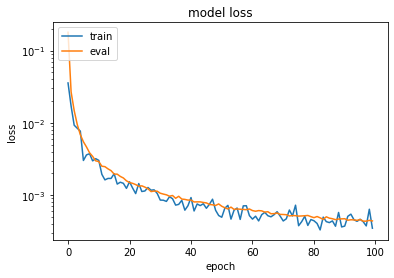

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)

plt.semilogy(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Step 2: Brigthness and Pixel Shift scattering
Here a higher number of epochs is used to reach the minimum loss function

In [6]:
Batch_Size = 8
Epoch_Anz = 600
Shift_Range = 3
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)


C:\Users\Muell\AppData\Local\Temp\ipykernel_20288\3747815558.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)


Epoch 1/600
701/701 [==============================] - 22s 31ms/step - loss: 0.0736 - accuracy: 0.9243 - val_loss: 0.0244 - val_accuracy: 0.9607
Epoch 2/600
701/701 [==============================] - 23s 32ms/step - loss: 0.0154 - accuracy: 0.9648 - val_loss: 0.0109 - val_accuracy: 0.9706
Epoch 3/600
701/701 [==============================] - 22s 31ms/step - loss: 0.0030 - accuracy: 0.9848 - val_loss: 0.0030 - val_accuracy: 0.9875
Epoch 12/600
701/701 [==============================] - 23s 33ms/step - loss: 0.0028 - accuracy: 0.9855 - val_loss: 0.0023 - val_accuracy: 0.9839
Epoch 13/600
701/701 [==============================] - 22s 30ms/step - loss: 0.0027 - accuracy: 0.9846 - val_loss: 0.0025 - val_accuracy: 0.9893
Epoch 14/600
701/701 [==============================] - 23s 32ms/step - loss: 0.0024 - accuracy: 0.9846 - val_loss: 0.0023 - val_accuracy: 0.9884
Epoch 15/600
701/701 [==============================] - 22s 32ms/step - loss: 0.0024 - accuracy: 0.9852 - val_loss: 0.0020 - va

701/701 [==============================] - 23s 33ms/step - loss: 8.6913e-04 - accuracy: 0.9925 - val_loss: 7.9897e-04 - val_accuracy: 0.9964
Epoch 89/600
701/701 [==============================] - 23s 32ms/step - loss: 8.4469e-04 - accuracy: 0.9927 - val_loss: 8.0291e-04 - val_accuracy: 0.9964
Epoch 90/600
701/701 [==============================] - 22s 32ms/step - loss: 8.5015e-04 - accuracy: 0.9950 - val_loss: 8.6372e-04 - val_accuracy: 0.9938
Epoch 91/600
701/701 [==============================] - 22s 32ms/step - loss: 8.3611e-04 - accuracy: 0.9934 - val_loss: 6.8886e-04 - val_accuracy: 0.9964
Epoch 92/600
701/701 [==============================] - 22s 32ms/step - loss: 8.2637e-04 - accuracy: 0.9934 - val_loss: 7.9014e-04 - val_accuracy: 0.9938
Epoch 93/600
701/701 [==============================] - 22s 31ms/step - loss: 8.2902e-04 - accuracy: 0.9920 - val_loss: 8.2347e-04 - val_accuracy: 0.9964
Epoch 94/600
701/701 [==============================] - 23s 33ms/step - loss: 8.4497e-04 

Epoch 163/600
701/701 [==============================] - 12s 17ms/step - loss: 6.5554e-04 - accuracy: 0.9925 - val_loss: 5.7044e-04 - val_accuracy: 0.9946
Epoch 164/600
701/701 [==============================] - 12s 16ms/step - loss: 6.5047e-04 - accuracy: 0.9948 - val_loss: 6.5796e-04 - val_accuracy: 0.9920
Epoch 165/600
701/701 [==============================] - 10s 14ms/step - loss: 6.7096e-04 - accuracy: 0.9938 - val_loss: 6.7062e-04 - val_accuracy: 0.9929
Epoch 166/600
701/701 [==============================] - 12s 17ms/step - loss: 6.4953e-04 - accuracy: 0.9930 - val_loss: 4.9941e-04 - val_accuracy: 0.9946
Epoch 167/600
701/701 [==============================] - 12s 17ms/step - loss: 6.5811e-04 - accuracy: 0.9932 - val_loss: 7.3555e-04 - val_accuracy: 0.9973
Epoch 168/600
701/701 [==============================] - 12s 17ms/step - loss: 6.2195e-04 - accuracy: 0.9941 - val_loss: 5.9140e-04 - val_accuracy: 0.9991
Epoch 169/600
701/701 [==============================] - 9s 13ms/step 

701/701 [==============================] - 9s 13ms/step - loss: 5.7603e-04 - accuracy: 0.9948 - val_loss: 6.5630e-04 - val_accuracy: 0.9911
Epoch 217/600
701/701 [==============================] - 9s 13ms/step - loss: 6.0294e-04 - accuracy: 0.9921 - val_loss: 5.9163e-04 - val_accuracy: 0.9946
Epoch 218/600
701/701 [==============================] - 8s 12ms/step - loss: 5.8020e-04 - accuracy: 0.9938 - val_loss: 5.1730e-04 - val_accuracy: 0.9973
Epoch 219/600
701/701 [==============================] - 8s 12ms/step - loss: 5.9672e-04 - accuracy: 0.9950 - val_loss: 6.1451e-04 - val_accuracy: 0.9973
Epoch 220/600
701/701 [==============================] - 8s 11ms/step - loss: 5.7576e-04 - accuracy: 0.9927 - val_loss: 5.0756e-04 - val_accuracy: 0.9955
Epoch 221/600
701/701 [==============================] - 8s 11ms/step - loss: 5.7968e-04 - accuracy: 0.9943 - val_loss: 6.2455e-04 - val_accuracy: 0.9982
Epoch 222/600
701/701 [==============================] - 8s 11ms/step - loss: 5.9143e-04 -

701/701 [==============================] - 7s 10ms/step - loss: 5.4719e-04 - accuracy: 0.9946 - val_loss: 4.8364e-04 - val_accuracy: 0.9982
Epoch 270/600
701/701 [==============================] - 7s 10ms/step - loss: 5.3593e-04 - accuracy: 0.9943 - val_loss: 4.7958e-04 - val_accuracy: 0.9964
Epoch 271/600
701/701 [==============================] - 7s 10ms/step - loss: 5.3151e-04 - accuracy: 0.9957 - val_loss: 6.5238e-04 - val_accuracy: 0.9946
Epoch 272/600
701/701 [==============================] - 7s 10ms/step - loss: 5.2870e-04 - accuracy: 0.9929 - val_loss: 4.9908e-04 - val_accuracy: 0.9946
Epoch 273/600
701/701 [==============================] - 7s 10ms/step - loss: 5.5379e-04 - accuracy: 0.9927 - val_loss: 4.9570e-04 - val_accuracy: 0.9946
Epoch 274/600
701/701 [==============================] - 7s 10ms/step - loss: 5.4622e-04 - accuracy: 0.9948 - val_loss: 4.5049e-04 - val_accuracy: 0.9991
Epoch 275/600
701/701 [==============================] - 7s 10ms/step - loss: 5.3471e-04 -

701/701 [==============================] - 7s 10ms/step - loss: 5.0764e-04 - accuracy: 0.9948 - val_loss: 4.8078e-04 - val_accuracy: 0.9964
Epoch 323/600
701/701 [==============================] - 7s 10ms/step - loss: 4.9910e-04 - accuracy: 0.9945 - val_loss: 4.0389e-04 - val_accuracy: 0.9973
Epoch 324/600
701/701 [==============================] - 7s 10ms/step - loss: 4.9443e-04 - accuracy: 0.9954 - val_loss: 4.4272e-04 - val_accuracy: 0.9973
Epoch 325/600
701/701 [==============================] - 7s 10ms/step - loss: 5.0707e-04 - accuracy: 0.9943 - val_loss: 4.8512e-04 - val_accuracy: 0.9964
Epoch 326/600
701/701 [==============================] - 7s 10ms/step - loss: 4.8553e-04 - accuracy: 0.9955 - val_loss: 4.3038e-04 - val_accuracy: 0.9929
Epoch 327/600
701/701 [==============================] - 7s 10ms/step - loss: 5.0126e-04 - accuracy: 0.9946 - val_loss: 4.1239e-04 - val_accuracy: 0.9991
Epoch 328/600
701/701 [==============================] - 7s 10ms/step - loss: 4.9247e-04 -

701/701 [==============================] - 7s 10ms/step - loss: 4.7764e-04 - accuracy: 0.9948 - val_loss: 4.5069e-04 - val_accuracy: 0.9991
Epoch 376/600
701/701 [==============================] - 7s 10ms/step - loss: 4.8557e-04 - accuracy: 0.9955 - val_loss: 5.1373e-04 - val_accuracy: 0.9955
Epoch 377/600
701/701 [==============================] - 7s 10ms/step - loss: 4.8495e-04 - accuracy: 0.9952 - val_loss: 4.4989e-04 - val_accuracy: 0.9973
Epoch 378/600
701/701 [==============================] - 7s 10ms/step - loss: 4.8061e-04 - accuracy: 0.9943 - val_loss: 4.7810e-04 - val_accuracy: 0.9929
Epoch 379/600
701/701 [==============================] - 7s 10ms/step - loss: 4.7437e-04 - accuracy: 0.9952 - val_loss: 4.7950e-04 - val_accuracy: 0.9964
Epoch 380/600
701/701 [==============================] - 7s 10ms/step - loss: 4.7247e-04 - accuracy: 0.9966 - val_loss: 4.2418e-04 - val_accuracy: 0.9955
Epoch 381/600
701/701 [==============================] - 7s 10ms/step - loss: 4.7722e-04 -

701/701 [==============================] - 7s 10ms/step - loss: 4.5832e-04 - accuracy: 0.9954 - val_loss: 4.1379e-04 - val_accuracy: 0.9964
Epoch 429/600
701/701 [==============================] - 7s 10ms/step - loss: 4.6499e-04 - accuracy: 0.9952 - val_loss: 4.7726e-04 - val_accuracy: 0.9955
Epoch 430/600
701/701 [==============================] - 7s 10ms/step - loss: 4.8184e-04 - accuracy: 0.9959 - val_loss: 3.8976e-04 - val_accuracy: 0.9964
Epoch 431/600
701/701 [==============================] - 7s 10ms/step - loss: 4.5076e-04 - accuracy: 0.9964 - val_loss: 5.0615e-04 - val_accuracy: 0.9946
Epoch 432/600
701/701 [==============================] - 7s 10ms/step - loss: 4.5291e-04 - accuracy: 0.9954 - val_loss: 4.7037e-04 - val_accuracy: 0.9973
Epoch 433/600
701/701 [==============================] - 7s 10ms/step - loss: 4.5364e-04 - accuracy: 0.9959 - val_loss: 3.9559e-04 - val_accuracy: 0.9973
Epoch 434/600
701/701 [==============================] - 7s 10ms/step - loss: 4.4665e-04 -

701/701 [==============================] - 7s 10ms/step - loss: 4.4175e-04 - accuracy: 0.9948 - val_loss: 4.0424e-04 - val_accuracy: 0.9973
Epoch 482/600
701/701 [==============================] - 7s 10ms/step - loss: 4.2159e-04 - accuracy: 0.9946 - val_loss: 4.4214e-04 - val_accuracy: 0.9964
Epoch 483/600
701/701 [==============================] - 7s 10ms/step - loss: 4.3368e-04 - accuracy: 0.9957 - val_loss: 3.6146e-04 - val_accuracy: 0.9964
Epoch 484/600
701/701 [==============================] - 7s 10ms/step - loss: 4.5628e-04 - accuracy: 0.9952 - val_loss: 3.9303e-04 - val_accuracy: 0.9964
Epoch 485/600
701/701 [==============================] - 7s 10ms/step - loss: 4.4420e-04 - accuracy: 0.9957 - val_loss: 3.6709e-04 - val_accuracy: 0.9991
Epoch 486/600
701/701 [==============================] - 7s 10ms/step - loss: 4.3451e-04 - accuracy: 0.9948 - val_loss: 4.3071e-04 - val_accuracy: 0.9946
Epoch 487/600
701/701 [==============================] - 7s 10ms/step - loss: 4.4848e-04 -

701/701 [==============================] - 7s 10ms/step - loss: 4.2999e-04 - accuracy: 0.9959 - val_loss: 4.5451e-04 - val_accuracy: 0.9973
Epoch 535/600
701/701 [==============================] - 7s 10ms/step - loss: 4.1676e-04 - accuracy: 0.9946 - val_loss: 3.8549e-04 - val_accuracy: 0.9982
Epoch 536/600
701/701 [==============================] - 7s 10ms/step - loss: 4.0809e-04 - accuracy: 0.9955 - val_loss: 3.9584e-04 - val_accuracy: 0.9964
Epoch 537/600
701/701 [==============================] - 7s 10ms/step - loss: 4.2190e-04 - accuracy: 0.9961 - val_loss: 4.1015e-04 - val_accuracy: 0.9964
Epoch 538/600
701/701 [==============================] - 7s 10ms/step - loss: 4.2099e-04 - accuracy: 0.9945 - val_loss: 4.5072e-04 - val_accuracy: 0.9973
Epoch 539/600
701/701 [==============================] - 7s 10ms/step - loss: 4.0828e-04 - accuracy: 0.9964 - val_loss: 4.7621e-04 - val_accuracy: 0.9973
Epoch 540/600
701/701 [==============================] - 7s 10ms/step - loss: 4.3607e-04 -

701/701 [==============================] - 7s 10ms/step - loss: 4.2179e-04 - accuracy: 0.9952 - val_loss: 3.3545e-04 - val_accuracy: 0.9973
Epoch 588/600
701/701 [==============================] - 7s 10ms/step - loss: 4.2501e-04 - accuracy: 0.9954 - val_loss: 3.5577e-04 - val_accuracy: 0.9982
Epoch 589/600
701/701 [==============================] - 7s 10ms/step - loss: 3.9418e-04 - accuracy: 0.9954 - val_loss: 3.4145e-04 - val_accuracy: 0.9982
Epoch 590/600
701/701 [==============================] - 7s 10ms/step - loss: 3.8849e-04 - accuracy: 0.9973 - val_loss: 3.3184e-04 - val_accuracy: 0.9982
Epoch 591/600
701/701 [==============================] - 7s 10ms/step - loss: 3.9951e-04 - accuracy: 0.9946 - val_loss: 3.3341e-04 - val_accuracy: 0.9973
Epoch 592/600
701/701 [==============================] - 7s 10ms/step - loss: 4.1955e-04 - accuracy: 0.9955 - val_loss: 4.4055e-04 - val_accuracy: 0.9964
Epoch 593/600
701/701 [==============================] - 7s 10ms/step - loss: 3.9414e-04 -

### Overall Learing results (Step 1 & Step 2)

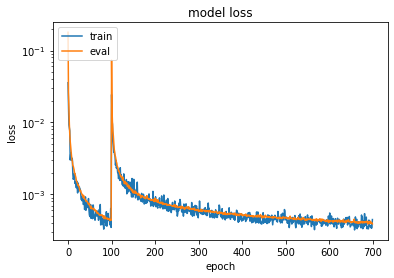

In [7]:
loss_ges = np.append(loss_ges, history.history['loss'])


if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)


plt.semilogy(loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* The evaluation takes the periodic character of the results into account (dev1 ... dev2).
* Images, that have a bigger deviation as the parameter "deviation_max_list" are printed in a list to check the picture and labeling itself

In [8]:
Input_dir='data_resize_all'
#Input_dir='test_result'
files = glob.glob(Input_dir + '/*.*')
res = []
stat_Anz = []
stat_Abweichung = []
i = 0
deviation_max_list = 0.05

for i in range(100):
    stat_Anz.append(0)
    stat_Abweichung.append(0)

for aktfile in files:
    base = os.path.basename(aktfile)
    target = (float(base[0:3])) / 10
    
    target_sin = math.sin(target * math.pi * 2)
    target_cos = math.cos(target * math.pi * 2)

    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img)
    
    out_sin = classes[0][0]  
    out_cos = classes[0][1]
    out_target = (np.arctan2(out_sin, out_cos)/(2*math.pi)) % 1

    dev_sin = target_sin - out_sin
    dev_cos = target_cos - out_cos
    dev_target = target - out_target
    
    if abs(dev_target + 1) < abs(dev_target):
        out_target = out_target - 1
        dev_target = target - out_target
    else:
        if abs(dev_target - 1) < abs(dev_target):
            out_target = out_target + 1
            dev_target = target - out_target
            
    target_int = int ((float(base[0:3])) * 10)
    stat_Abweichung[target_int] = stat_Abweichung[target_int] + dev_target  
    stat_Anz[target_int] = stat_Anz[target_int] + 1
               
    res.append(np.array([target, out_target, dev_target, out_sin, out_cos, i]))
    if abs(dev_target) > deviation_max_list:
        print(aktfile + " " + str(target) + " " + str(out_target) +  " " + str(dev_target))

    
for i in range(100):
    stat_Abweichung[i] = stat_Abweichung[i] / stat_Anz[i]

res = np.asarray(res)
res_step_1 = res

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
data_resize_all\0.5_0213_zeiger4_2020-04-29_13-45-02.jpg 0.05 0.14662357604892526 -0.09662357604892526
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
data_resize_all\1.8_0836_zeiger3_2020-04-29_11-07-53.jpg 0.18 0.12442402880393288 0.05557597119606711
1/1 [==============================] - 0s 16ms/step
data_resize_all\1.8_ana4_20220629-153729.jpg 0.18 0.09273322222916924 0.08726677777083075
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
data_resize_all\2.6_pointer_20211015-141107.jpg 0.26 0.3157091588480745 -0.05570915884807448
1/1 [==============================] - 0s 16ms/step
data_resize_all\2.6_pointer_20211015-141730.jpg 0.26 0.31025815562621656 -0.05025815562621655
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
data_resize_all\2.8_pointer_20211006-194409.jpg 0.27999999999999997 0.33018663651305813 -0.05018663651305816
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
data_resize_all\4.7.jpg 0.47000000000000003 0.5210000098173628 -0.0510000098173628
1/1 [==============================] - 0s 15ms/step
data_resize_all\4.7_2365_zeiger1_2019-06-06T045009.jpg 0.47000000000000003 0.4174206742275993 0.05257932577240071
1/1 [==============================] - 0s 14ms/step
data_resize_all\4.7_2366_zeiger1_2019-06-06T050009.jpg 0.47000000000000003 0.41960561379759104 0.05039438620240899
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
data_resize_all\5.1_PRODUCED_ANALOG_2.jpg 0.51 0.45854216963511957 0.05145783036488044
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
data_resize_all\5.5_PRODUCED_ANALOG.jpg 0.55 0.6130412485062451 -0.06304124850624504
1/1 [==============================] - 0s 16ms/step
data_resize_all\5.5_PRODUCED_ANALOG_2.jpg 0.55 0.6025002555056599 -0.05250025550565984
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 14ms/step
data_resize_all\5.9.jpg 0.5900000000000001 0.723718923963975 -0.1337189239639749
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step
data_resize_all\8.1.jpg 0.8099999999999999 0.7457176351882475 0.06428236481175242
1/1 [==============================] - 0s 15ms/step
data_resize_all\8.2.jpg 0.82 0.8794166055391129 -0.05941660553911299
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
data_resize_all\8.4_4212_analog4_20200813-111418.jpg 0.8400000000000001 1.0135086900364114 -0.17350869003641134
1/1 [==============================] - 0s 14ms/step
data_resize_all\8.6.jpg 0.86 0.9226074016194271 -0.06260740161942713
1/1 [==============================] - 0s 15ms/step
data_resize_all\8.6_4219_zeiger2_2019-06-03T183009.jpg 0.86 0.916268312537112 -0.056268312537112064
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
data_resize_all\9.8_4932_zeiger3_2020-04-29_14-00-02.jpg 0.9800000000000001 0.9275230271036553 0.05247697289634479
1/1 [==============================] - 0s 15ms/step


## Results

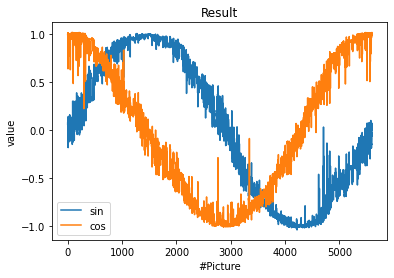

In [9]:
plt.plot(res[:,3])
plt.plot(res[:,4])
plt.title('Result')
plt.ylabel('value')
plt.xlabel('#Picture')
plt.legend(['sin', 'cos'], loc='lower left')
plt.show()

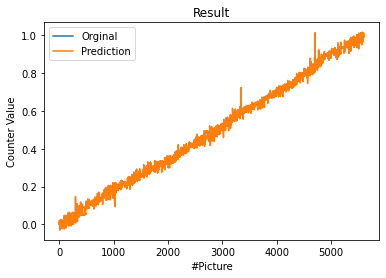

In [10]:
plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

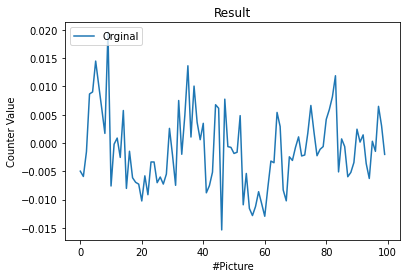

In [11]:
plt.plot(stat_Abweichung)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

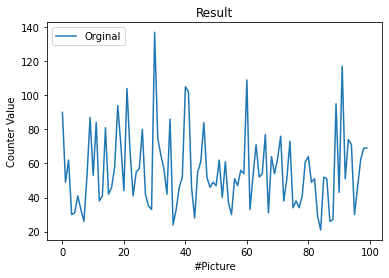

In [12]:
plt.plot(stat_Anz)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

### Deviation from Expected Value

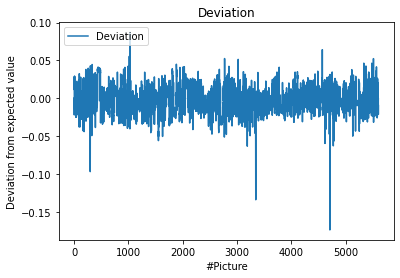

[-0.0015  0.0162 -0.1735  0.0873]


In [13]:
plt.plot(res[:,2])
plt.title('Deviation')
plt.ylabel('Deviation from expected value')
plt.xlabel('#Picture')
plt.legend(['Deviation'], loc='upper left')
#plt.ylim(-0.3, 0.3)
plt.show()

statistic = np.array([np.mean(res[:,2]), np.std(res[:,2]), np.min(res[:,2]), np.max(res[:,2])])
print(statistic)

### Save the model

* Save the model to the file with the "h5" file format

In [14]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpyi0_ot81\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpyi0_ot81\assets


125772

In [15]:
from pathlib import Path
import tensorflow as tf

FileName = TFliteNamingAndVersion + "q" + ".tflite"

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]

converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpu01pj4gu\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpu01pj4gu\assets
C:\Users\Muell\anaconda3\envs\py39-tf-opencv\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


ana1000s3_longq.tflite


38544